# Notebook to run grn inference on jcf cells

## Get anndata metacell object

In [1]:
.libPaths(c("/home/icb/laura.martens/miniconda3/envs/archr/lib/R/library", "/home/icb/laura.martens/miniconda3/envs/signac/lib/R/library"))

In [2]:
fig_path <- '/lustre/groups/ml01/workspace/laura.martens/moretti_colab/panels/jcf/'

In [3]:
library(anndata)
library(data.table)
library(Signac)
library(Seurat)
library(Matrix)
library(Pando)

Attaching SeuratObject

Attaching sp



In [4]:
library(rtracklayer)


Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:Matrix’:

    expand, unname


The following objects are masked from ‘package:data.table’:

    first, second


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


In [5]:
adata <- read_h5ad('/lustre/groups/ml01/workspace/laura.martens/moretti_colab/scglue/metacells_imputed.h5ad')

In [279]:
peaks <- fread('/lustre/groups/ml01/workspace/laura.martens/moretti_colab/scglue/peak_names.csv', header=FALSE)

In [280]:
adata

AnnData object with n_obs × n_vars = 35499 × 24171
    obs: 'clusters', 'day', 'tech', 'atac_match', 'atac_barcode', 'leiden_res0.3', 'leiden_res0.5', 'leiden_res0.8', 'leiden_res1', 'MAB21L2_act', 'HAND1_act', 'MEF2C_act', 'GATA4_act', 'ISL1_act', 'FOS_act'
    var: 'gene', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'transcript_id', 'gene_type', 'gene_status', 'transcript_type', 'transcript_status', 'transcript_name', 'havana_gene', 'tag'
    uns: 'atac_peaks', 'clusters_colors', 'day_colors', 'gene_names', 'hvg', 'leiden', 'leiden_res0.3_colors', 'leiden_res0.5_colors', 'leiden_res0.8_colors', 'leiden_res1_colors', 'log1p', 'motif_names', 'neighbors', 'pca', 'rank_genes_res1', 'umap'
    obsm: 'X_glue', 'X_pca', 'X_umap', 'activities', 'activities_imputed', 'atac_counts', 'chromv

## Create seurat object with one assay for atac and one for RNA

### ATAC

In [152]:
atac_counts <- adata$obsm$atac_counts

In [153]:
rownames(atac_counts) <- adata$obs_names

In [154]:
colnames(atac_counts) <- peaks$V1

In [155]:
chrom_assay <- CreateChromatinAssay(
  counts = t(atac_counts),
  sep = c("-", "-"),
  genome = 'hg19',
  min.cells = 0,
  min.features = 0
)

In [156]:
chrom_assay

ChromatinAssay data with 162003 features for 35499 cells
Variable features: 0 
Genome: hg19 
Annotation present: FALSE 
Motifs present: FALSE 
Fragment files: 0 

In [157]:
atac <- CreateSeuratObject(
  counts = chrom_assay,
  assay = "peaks",
  meta.data = adata$obs
)

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from peaks to peaks_”


In [158]:
hg19 <- rtracklayer::import("/lustre/groups/ml01/workspace/laura.martens/moretti_colab/pando/gencode.v28lift37.basic.annotation.gtf.gz")

genome(hg19) <- "hg19"
seqlevelsStyle(hg19) <- "UCSC"
hg19$gene_biotype <- hg19$gene_type

DefaultAssay(atac) <- "peaks"

Annotation(atac) <- hg19

In [159]:
# # extract gene annotations from EnsDb
# library(EnsDb.Hsapiens.v75)
# annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v75)

# # change to UCSC style since the data was mapped to hg19
# seqlevelsStyle(annotations) <- 'UCSC'

# # add the gene information to the object
# Annotation(atac) <- annotations

### RNA

In [160]:
adata_rna <- read_h5ad('/lustre/groups/ml01/workspace/laura.martens/moretti_colab/scglue/adata_rna_counts.h5ad')

In [161]:
rna_counts <- t(adata_rna$X)

In [162]:
colnames(rna_counts) <- adata_rna$obs_names

In [163]:
rownames(rna_counts) <- adata_rna$var_names

In [164]:
# create a new assay to store ADT information
rna_assay <- CreateAssayObject(counts = rna_counts)

In [165]:
# add this assay to the previously created Seurat object
atac[["RNA"]] <- rna_assay

# Validate that the object now contains multiple assays
Assays(atac)

[1] "peaks" "RNA"

In [166]:
DefaultAssay(atac) <- "RNA"

### Find variable features

In [167]:
atac <- NormalizeData(atac, normalization.method = "LogNormalize", scale.factor = 10000)

In [168]:
atac <- FindVariableFeatures(atac, selection.method = "vst", nfeatures = 4000)

### Compute PCA

In [169]:
atac <- ScaleData(atac)

Centering and scaling data matrix



In [170]:
atac <- RunPCA(atac)

PC_ 1 
Positive:  TNNT2, ACTC1, TTN, MYL4, MYL7, TNNI1, CTD-2545M3.8, TPM1, MYH6, TNNC1 
	   FILIP1, NEBL, ACTA2, SORBS2, HSPB7, SLC8A1, MYBPC3, ACTN2, SLC25A4, SMPX 
	   NEXN, ENO3, LDB3, TECRL, PDLIM5, MYL3, RYR2, HSPB1, CSRP3, MYOM1 
Negative:  RPS6, HMGB1, RPS3, HMGA1, RPSA, TUBB, RANBP1, CYP26A1, PTMA, SNRPB 
	   L1TD1, TUBA1C, TKT, RAN, H2AFZ, TMSB4X, ACTG1, HMGN2, CKS1B, NPM1 
	   POU5F1, GJA1, RPL12, HMGB3, GSTP1, NASP, TUBB2B, MGST1, EEF1B2, RPL8 
PC_ 2 
Positive:  KRT19, TMEM88, PTPN13, DHRS3, PDGFRA, FN1, PTGIS, TFPI, PRTG, IGF2 
	   FLRT3, CTSV, ISL1, MEIS2, KRT8, FAM213A, HOTAIRM1, S100A10, APOA1, S100A13 
	   APOA2, RP11-834C11.4, VIM, SFRP5, LAMA1, TMEM141, ATP2B1, RP11-771K4.1, CRABP2, PBX1 
Negative:  MIXL1, POU5F1, TDGF1, GAL, EOMES, PPP1R14B, SFRP2, NODAL, IER3, SP5 
	   MESP1, C1QBP, FGF17, NTS, CER1, L1TD1, FAM159B, ATP5D, TUBB2A, CD9 
	   CCND1, PGP, YBX1, CDA, IGFBP2, RP4-792G4.2, T, GLRX5, LAPTM4B, CRABP1 
PC_ 3 
Positive:  VIM, LIX1, TMEM88, CRABP2, EMP2, NRP2,

### LSI

In [173]:
DefaultAssay(atac) <- "peaks"

In [174]:
atac <- RunTFIDF(atac)
atac <- FindTopFeatures(atac, min.cutoff = 'q0')
atac <- RunSVD(atac)

Performing TF-IDF normalization

Running SVD

Scaling cell embeddings



### Load example data

In [ ]:
# library(tidyverse)
# muo_data <- read_rds('/lustre/groups/ml01/workspace/laura.martens/moretti_colab/pando/muo_data.rds')
# muo_data

# DimPlot(muo_data)

# mean(muo_data[["peaks"]]@counts)

### Add latent embedding

In [175]:
atac@reductions$xglue = atac@reductions$pca

xglue <- adata$obsm$X_glue

rownames(xglue) <- adata$obs_names

colnames(xglue) <- seq(1, ncol(xglue))

atac@reductions$xglue@cell.embeddings <- xglue

### Run pseudocell algorithm

In [76]:
suppressMessages(source('pseudocells.r'))

In [176]:
atac <- find_pseudocells(atac, reduction='xglue')

# atac

# DefaultAssay(atac) <- "peaks"

# atac <- Pando::aggregate_assay(atac, assay='peaks_bin', group_name='pseudocell', fun='mean')
# atac <- Pando::aggregate_assay(atac, assay='peaks', group_name='pseudocell', fun='sum')
# atac <- Pando::aggregate_assay(atac, assay='RNA', group_name='pseudocell', fun='mean')

Computing nearest neighbor graph



[1] 10666
[1] 4.2
[1] 10662
[1] 35499


### Save rds object

In [178]:
#
saveRDS(atac, "/lustre/groups/ml01/workspace/laura.martens/moretti_colab/pando/atac.rds")

In [30]:
#saveRDS(grn_obj, "/lustre/groups/ml01/workspace/laura.martens/moretti_colab/pando/grn_obj_filtered_atac_cellrank.rds")

In [180]:
8

[1] 8

## Run Pando

In [181]:
#atac <- readRDS("/lustre/groups/ml01/workspace/laura.martens/moretti_colab/pando/atac.rds")

### Lift over annotations from Pando package

In [182]:
library(liftOver)

Loading required package: gwascat

gwascat loaded.  Use makeCurrentGwascat() to extract current image.

 from EBI.  The data folder of this package has some legacy extracts.

Loading required package: Homo.sapiens

Loading required package: AnnotationDbi

Loading required package: Biobase

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.



Attaching package: ‘Biobase’


The following objects are masked from ‘package:matrixStats’:

    anyMissing, rowMedians



Attaching package: ‘AnnotationDbi’


The following object is masked from ‘package:tidygraph’:

    select


The following object is masked from ‘package:dplyr’:

    select


Loading required package: OrganismDbi

Loading required package: GenomicFeatures

Loading required package: GO.db



Loading required package: org.Hs.eg.db



Loading required package: TxDb.Hsapiens.UCSC.hg19.k

In [183]:
library(rtracklayer)
path = system.file(package="liftOver", "extdata", "hg38ToHg19.over.chain")
ch = import.chain(path)

#### Conservation scores

In [184]:
seqlevelsStyle(phastConsElements20Mammals.UCSC.hg38) = "UCSC"  # necessary
phastConsElements20Mammals.UCSC.hg19 = liftOver(phastConsElements20Mammals.UCSC.hg38, ch)
phastConsElements20Mammals.UCSC.hg19 = unlist(phastConsElements20Mammals.UCSC.hg19)

genome(phastConsElements20Mammals.UCSC.hg19) = "hg19"
seqlevelsStyle(phastConsElements20Mammals.UCSC.hg19) = "UCSC"

Discarding unchained sequences: chr1_GL383518v1_alt, chr1_GL383519v1_alt, chr1_GL383520v2_alt, chr1_KI270709v1_random, chr1_KI270710v1_random, chr1_KI270712v1_random, chr1_KI270713v1_random, chr1_KI270714v1_random, chr1_KI270759v1_alt, chr1_KI270760v1_alt, chr1_KI270761v1_alt, chr1_KI270762v1_alt, chr1_KI270763v1_alt, chr1_KI270764v1_alt, chr1_KI270765v1_alt, chr1_KI270892v1_alt, chr2_GL383521v1_alt, chr2_GL383522v1_alt, chr2_GL582966v2_alt, chr2_KI270767v1_alt, chr2_KI270768v1_alt, chr2_KI270769v1_alt, chr2_KI270770v1_alt, chr2_KI270771v1_alt, chr2_KI270772v1_alt, chr2_KI270773v1_alt, chr2_KI270774v1_alt, chr2_KI270775v1_alt, chr2_KI270776v1_alt, chr2_KI270893v1_alt, chr2_KI270894v1_alt, chr3_GL000221v1_random, chr3_GL383526v1_alt, chr3_JH636055v2_alt, chr3_KI270777v1_alt, chr3_KI270778v1_alt, chr3_KI270779v1_alt, chr3_KI270780v1_alt, chr3_KI270781v1_alt, chr3_KI270782v1_alt, chr3_KI270783v1_alt, chr3_KI270784v1_alt, chr3_KI270895v1_alt, chr3_KI270924v1_alt, chr3_KI270934v1_alt, chr3_

#### cCREs elements

In [185]:
# data('SCREEN.ccRE.UCSC.hg38')

# seqlevelsStyle(SCREEN.ccRE.UCSC.hg38) = "UCSC"  # necessary
# SCREEN.ccRE.UCSC.hg19 = liftOver(SCREEN.ccRE.UCSC.hg38, ch)
# SCREEN.ccRE.UCSC.hg19 = unlist(SCREEN.ccRE.UCSC.hg19)

# genome(SCREEN.ccRE.UCSC.hg19) = "hg19"
# seqlevelsStyle(SCREEN.ccRE.UCSC.hg19) = "UCSC"

### Filter atac to interesting cluster

In [186]:
atac_14 <- atac[, atac[[]]$leiden_res1 == '14']

In [38]:
#atac_14 <- atac_14[, atac_14[[]]$atac_match == 1]

In [187]:
#atac_14 <- FindVariableFeatures(atac_14, selection.method = "vst", nfeatures = 4000)

### Initiate GRN

In [188]:
grn_obj <- initiate_grn(
    atac_14,
    rna_assay = 'RNA',
    peak_assay = 'peaks',
    regions = phastConsElements20Mammals.UCSC.hg19 
)

In [189]:
grn_obj

An object of class SeuratPlus 
186174 features across 893 samples within 2 assays 
Active assay: peaks (162003 features, 162003 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, lsi, xglue

### Find motifs

In [190]:
library(BSgenome.Hsapiens.UCSC.hg19)
data(motifs)
data('motif2tf')

Loading required package: BSgenome

Loading required package: Biostrings

Loading required package: XVector


Attaching package: ‘XVector’


The following object is masked from ‘package:plyr’:

    compact


The following object is masked from ‘package:purrr’:

    compact



Attaching package: ‘Biostrings’


The following object is masked from ‘package:ape’:

    complement


The following object is masked from ‘package:pals’:

    alphabet


The following object is masked from ‘package:base’:

    strsplit




#### Restrict to genes and TFs from CellRank

In [191]:
# library(stringr)

# epi_gene <- fread("/lustre/groups/ml01/workspace/laura.martens/moretti_colab/panels/jcf/jcf_epicardial_gene_drivers_14.csv")
# epi_motif <- fread("/lustre/groups/ml01/workspace/laura.martens/moretti_colab/panels/jcf/jcf_epicardial_motif_drivers_14.csv")

# cm_gene <- fread("/lustre/groups/ml01/workspace/laura.martens/moretti_colab/panels/jcf/jcf_cm_gene_drivers_14.csv")
# cm_motif <- fread("/lustre/groups/ml01/workspace/laura.martens/moretti_colab/panels/jcf/jcf_cm_motif_drivers_14.csv")

# epi_genes <- epi_gene %>%
#     dplyr::filter(Epicardial_corr > 0) %>%
#     pull(V1)%>%
#     toupper()

# cm_genes <- cm_gene %>%
#     dplyr::filter(Cardiomyocyte_corr > 0) %>%
#     pull(V1)%>%
#     toupper()

# epi_tfs <- epi_motif %>% 
#     pull(V1) %>%
#     toupper()

# cm_tfs <- cm_motif %>% 
#     pull(V1) %>%
#     toupper()

# tfs <- c(cm_tfs, epi_tfs)

# genes <- c(cm_genes, epi_genes)

# motif2tf_use <- motif2tf %>%
#     dplyr::filter((tf %in% tfs) | (tf %in% genes))

# motifs_use <- motifs[unique(motif2tf_use$motif)]


# head(motif2tf_use, 40)

# grn_obj[["RNA"]]@var.features <- genes

#### Find motifs

In [192]:
grn_obj <- find_motifs(
    grn_obj,
    pfm = motifs,
    genome = BSgenome.Hsapiens.UCSC.hg19
)

Adding TF info

Building motif matrix

Warning message in .Seqinfo.mergexy(x, y):
“Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chrMT, chr4_ctg9_hap1, chr6_apd_hap1, chr6_cox_hap2, chr6_dbb_hap3, chr6_mann_hap4, chr6_mcf_hap5, chr6_qbl_hap6, chr6_ssto_hap7, chr17_ctg5_hap1, chr1_gl000191_random, chr1_gl000192_random, chr4_gl000193_random, chr4_gl000194_random, chr7_gl000195_random, chr8_gl000196_random, chr8_gl000197_random, chr9_gl000198_random, chr9_gl000199_random, chr9_gl000200_random, chr9_gl000201_random, chr11_gl000202_random, chr17_gl000203_random, chr17_gl000204_random, chr17_gl000205_random, chr17_gl000206_random, chr18_gl000207_random, chr19_gl000208_random, chr19_gl000209_random, chr21_gl000210_random, chrUn_gl000211, chrUn_gl000212, chrUn_gl000213, chrUn_gl000214, chrUn_gl000215, chrUn_gl000216, chrUn_gl000217, chrUn_gl000218, chrUn_gl000219, chrUn_gl000220, chrUn_gl000221, chrUn_gl000222, chrUn_gl000223, chrUn_gl000224, chrUn_gl000225, 

### Infer GRN

In [193]:
library(doParallel)
registerDoParallel(8)
grn_obj <- infer_grn(
    grn_obj,
    peak_to_gene_method = 'Signac',
    parallel = T,
    method='glm',
    aggregate_rna_col = 'pseudocell',
    aggregate_peaks_col = 'pseudocell',
)

Loading required package: foreach


Attaching package: ‘foreach’


The following objects are masked from ‘package:purrr’:

    accumulate, when


Loading required package: iterators

Loading required package: parallel

Selecting candidate regulatory regions near genes

Preparing model input

Fitting models for 3879 target genes



### Save GRN

In [194]:
saveRDS(grn_obj, "/lustre/groups/ml01/workspace/laura.martens/moretti_colab/pando/grn_obj_final_pseudocells.rds")

# Load grn

In [6]:
grn_obj <- readRDS("/lustre/groups/ml01/workspace/laura.martens/moretti_colab/pando/grn_obj_final.rds")

In [7]:
grn_obj

An object of class SeuratPlus 
186174 features across 893 samples within 2 assays 
Active assay: peaks (162003 features, 162003 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, lsi

### Find modules

In [8]:
grn_obj <- find_modules(
    grn_obj, 
    p_thresh = 0.05,
    nvar_thresh = 2, 
    min_genes_per_module = 1, 
    rsq_thresh = 0.05
)

Found 410 TF modules



### Visualization

In [8]:
g <- plot_gof(grn_obj, point_size=3)
ggsave(paste0(fig_path, 'variables_r2.pdf'), g, width=6, height=6, device = cairo_pdf,)

Warning message:
“Using alpha for a discrete variable is not advised.”


ERROR: Error in ggsave(paste0(fig_path, "variables_r2.pdf"), g, width = 6, height = 6, : could not find function "ggsave"


In [ ]:
g

In [434]:
g <- plot_module_metrics(grn_obj)
ggsave(paste0(fig_path, 'number_of_targets.pdf'), g, width=10, height=6, device = cairo_pdf)

## Downstream analysis

In [9]:
suppressWarnings(library(tidyverse))

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0          ✔ purrr   0.3.5     
✔ tibble  3.1.8          ✔ dplyr   1.0.10    
✔ tidyr   1.2.1.9001     ✔ stringr 1.4.1.9000
✔ readr   2.1.2          ✔ forcats 0.5.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()    masks data.table::between()
✖ dplyr::collapse()   masks IRanges::collapse()
✖ dplyr::combine()    masks BiocGenerics::combine()
✖ dplyr::desc()       masks IRanges::desc()
✖ tidyr::expand()     masks S4Vectors::expand(), Matrix::expand()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::first()      masks S4Vectors::first(), data.table::first()
✖ dplyr::lag()        masks stats::lag()
✖ dplyr::last()       masks data.table::last()
✖ tidyr::pack()       masks Matrix::pack()
✖ ggplot2::Position() masks BiocGenerics::Position(), base::Position()
✖ readr::read_csv()   masks anndata::read_csv()
✖ purrr::reduce()     masks Geno

In [77]:
library(dplyr) 
library(tibble) 
library(ggplot2)
library(ggraph)
library(tidygraph)
library(pals)
library(tidyverse)
library(raster)
#library(pbapply)
suppressMessages(source('pseudocells.r'))

In [11]:
#grn_obj <- get_network_graph(grn_obj, umap_method='none', graph_name = 'full_graph', features=genes_show)

In [12]:
#plot_network_graph(grn_obj, graph = 'full_graph')

### Load modules

In [13]:
modules <- NetworkModules(grn_obj, network=DefaultNetwork(grn_obj))@meta

In [14]:
genes_show <- unique(modules$tf)

### Greate network based on UMAP

In [15]:
DefaultAssay(grn_obj) <- "RNA"

In [16]:
get_umap <- function(
    x,
    n_pcs = 30,
    ...
){
    set.seed(111)
    if (ncol(x)>100){
        pca_mat <- irlba::prcomp_irlba(x, n=n_pcs)$x
        rownames(pca_mat) <- rownames(x)
        x <- as.matrix(pca_mat)
    }
    umap_tbl <- uwot::umap(x, ...) %>%
        {colnames(.) <- c('UMAP_1', 'UMAP_2'); .} %>%
        as_tibble(rownames='gene')
    return(umap_tbl)
}


In [17]:
rna_expr <- t(Seurat::GetAssayData(grn_obj, assay="RNA", slot="data"))

In [18]:
# All TFs that are in variable features

features <- VariableFeatures(grn_obj)#genes_show#colnames(rna_expr)
features <- features[features %in% motif2tf$tf]
features <- unique(c(features, genes_show))

In [19]:
rna_expr <- rna_expr[, features]

In [20]:
gene_cor <- sparse_cor(rna_expr)

In [21]:
gene_cor_df <- gene_cor %>%
    as_tibble(rownames='source') %>%
    pivot_longer(!source, names_to='target', values_to='corr')

In [22]:
modules_use <- NetworkModules(grn_obj, network=DefaultNetwork(grn_obj))@meta %>%
    filter( tf%in%colnames(rna_expr))

In [23]:
gene_net <- modules_use %>%
    dplyr::select(tf, target, everything()) %>%
    full_join(gene_cor_df, by=c('tf'='source', 'target')) %>%
    {.$corr[is.na(.$corr)] <- 0; .}

In [24]:
# All genes
reg_mat <- gene_net %>%
    dplyr::select(target, tf, estimate) %>%
    pivot_wider(names_from=target, values_from=estimate, values_fill=0) %>%
    column_to_rownames('tf') %>% mutate_all(~replace(., is.na(.), 0)) %>% 
    dplyr::select(all_of(features)) %>%
as.matrix()

In [25]:
reg_factor_mat <- abs(reg_mat) + 1
coex_mat <- gene_cor[rownames(reg_factor_mat), colnames(reg_factor_mat)] * sqrt(reg_factor_mat)

In [26]:
set.seed(111)
coex_umap <- get_umap(as.matrix(coex_mat))

In [27]:
gene_graph <- as_tbl_graph(modules_use) %>%
    activate(edges) %>%
    mutate(from_node=.N()$name[from], to_node=.N()$name[to]) %>%
    mutate(dir=sign(estimate)) %>%
    activate(nodes) %>%
    mutate(centrality=centrality_pagerank()) %>%
    inner_join(coex_umap, by=c('name'='gene'))

In [28]:
grn_obj@grn@networks[[DefaultNetwork(grn_obj)]]@graphs[['test_graph']] <- gene_graph

### Visualize Graph

In [29]:
gene_graph <- NetworkGraph(grn_obj, network=DefaultNetwork(grn_obj), graph='test_graph')

In [30]:
tf_meta <- modules %>% ungroup() %>% 
  distinct('name'=tf, n_genes)
target_meta <- modules %>% ungroup() %>% 
  distinct('name'=target, n_tfs)

#### Color nodes by absorption probability weighted expression

In [31]:
absorption_prob <- read.csv('/lustre/groups/ml01/workspace/laura.martens/moretti_colab/pando/absorption_prob.csv')

In [32]:
expr_mat <- GetAssayData(grn_obj[["RNA"]])

In [33]:
weighted_abs_pt <- apply(expr_mat, 1, function(x){
    non0 <- which(x!=0)
    wex <- weighted.mean(absorption_prob$Epicardial_zscore[non0], x[non0])
    return(wex)
})

weighted_abs_pt <- data.frame(name=names(weighted_abs_pt), absorption_prob_weighted_expr=weighted_abs_pt) %>% as_tibble()

In [34]:
lineage_correlation <- read.csv("/lustre/groups/ml01/workspace/laura.martens/moretti_colab/panels/jcf/jcf_epicardial_gene_drivers_14.csv")

In [35]:
grn_graph <- as_tbl_graph(modules, directed=FALSE) %>% 
  activate(edges) %>% 
  mutate(from_node=.N()$name[from], to_node=.N()$name[to]) %>% 
  activate(nodes) %>% left_join(tf_meta) %>% left_join(target_meta) %>% 
  inner_join(dplyr::select(as_tibble(activate(gene_graph, nodes)), name, UMAP_1, UMAP_2)) %>% 
  left_join(weighted_abs_pt) %>%
     left_join(lineage_correlation, by=c("name"="X")) %>%
  mutate(
    central_pr = centrality_pagerank(weights = estimate),
    central_betw = centrality_betweenness(),
    central_eig = centrality_eigen(),
    centrality_auth = centrality_authority(),
    central_hub = centrality_hub(weights=estimate),
    central_outdegree = centrality_degree(mode='out'),
    central_indegree = centrality_degree(mode='in'),
    central_harm = centrality_closeness_harmonic(),
    central_gen = centrality_closeness_generalised(alpha=0.1),
    central_int = centrality_integration(),
    central_comm = as.double(centrality_communicability()),
#    central_curr = centrality_betweenness_current()
  ) %>% to_undirected() %>% 
  mutate(
    group_louvain=group_louvain()
  ) 

Joining, by = "name"
Joining, by = "name"
Joining, by = "name"
Joining, by = "name"
Warning message in betweenness(graph = graph, v = V(graph), directed = directed, :
“'nobigint' is deprecated since igraph 1.3 and will be removed in igraph 1.4”
as(<dsCMatrix>, "dgCMatrix") is deprecated since Matrix 1.5-0; do as(., "generalMatrix") instead



In [37]:
highlight_genes <- c("TAL2",
"HOXB1",
"ETV1",
"MEIS1",
"GATA4",
"HEY1",
"MEF2C",
"IRX4",
"IRX5", 
"BACH2",
"EGR1",
"WT1",
"BNC2",
"FOS",
"TFAP2B",
"GRHL2",
"RUNX1",
"TFAP2A"                   )

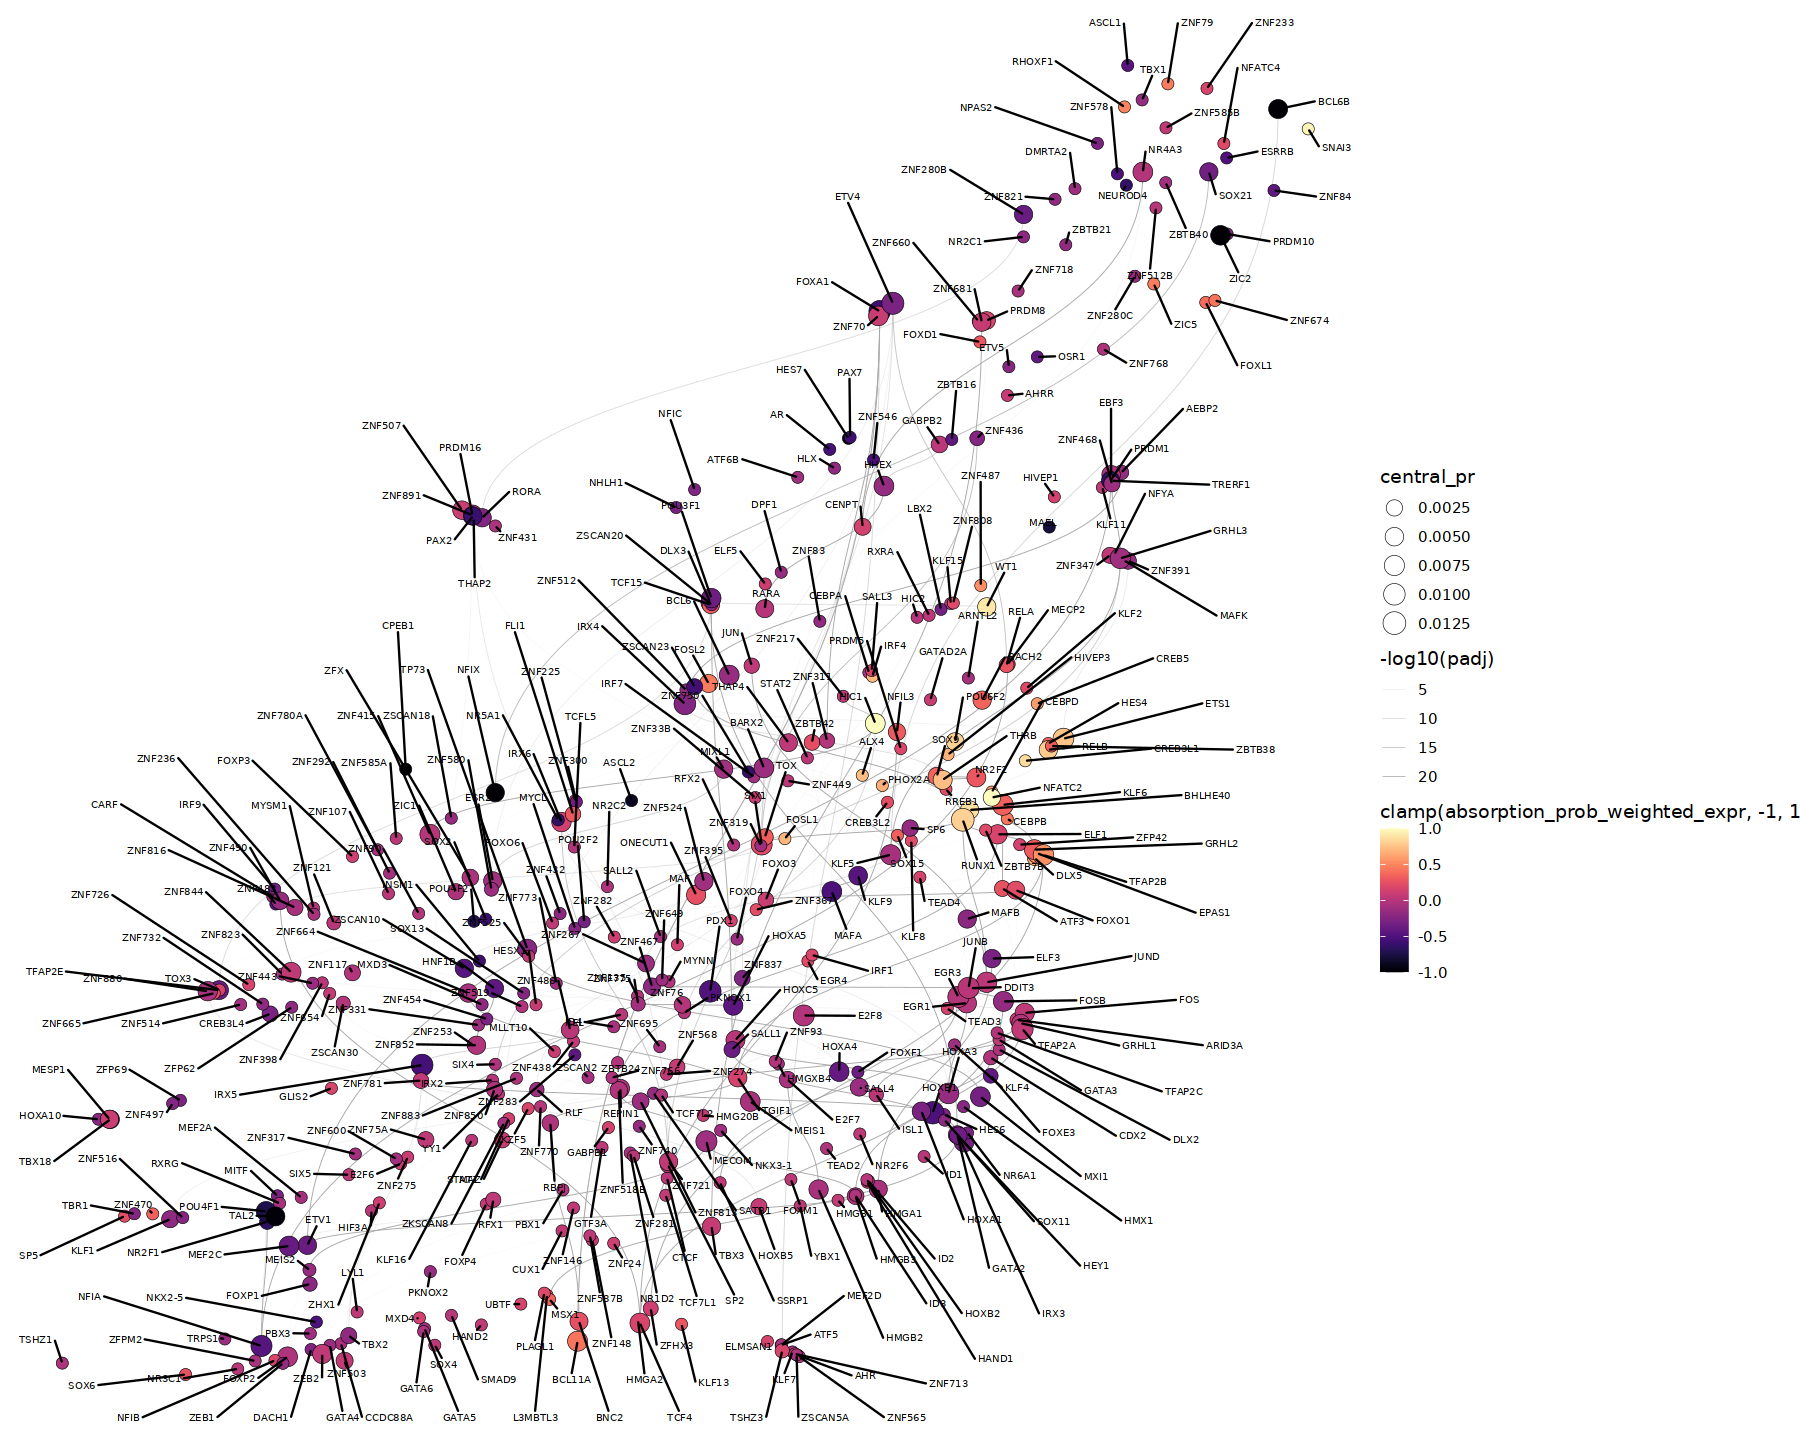

In [51]:
options(repr.plot.width=15, repr.plot.height=12)
# grn_graph %>%
#     filter(UMAP_1 > -1, UMAP_2 > -1) %>%
g <- ggraph(grn_graph, x=UMAP_1, y=UMAP_2) + 
    geom_edge_diagonal(aes(alpha=-log10(padj)), color='darkgray', width=0.2) + 
    geom_node_point(aes(fill=clamp(absorption_prob_weighted_expr, -1,1), size=central_pr), shape=21, stroke=0.2) +
    geom_node_text(aes(label=name, size=central_pr), repel=T, max.overlaps=1000, size=2, min.segment.length=0, box.padding=0.8) +
    #geom_node_text(aes(label=name, size=2)) +
    #scale_edge_color_gradientn(colors=rev(rdbu()), limits=c(-6,6)) +
    scale_edge_alpha_continuous(range=c(0.01,0.8), limits=c(2,20)) +
    scale_size_continuous(range=c(3, 6)) + 
    scale_fill_viridis(option='magma', direction = 1) +
    theme(text=element_text(family='Arial')) + 
    #scale_fill_distiller(palette='RdBu', limits=c(-1, 1), direction=-1)+
    theme_void() #+ no_legend()
g

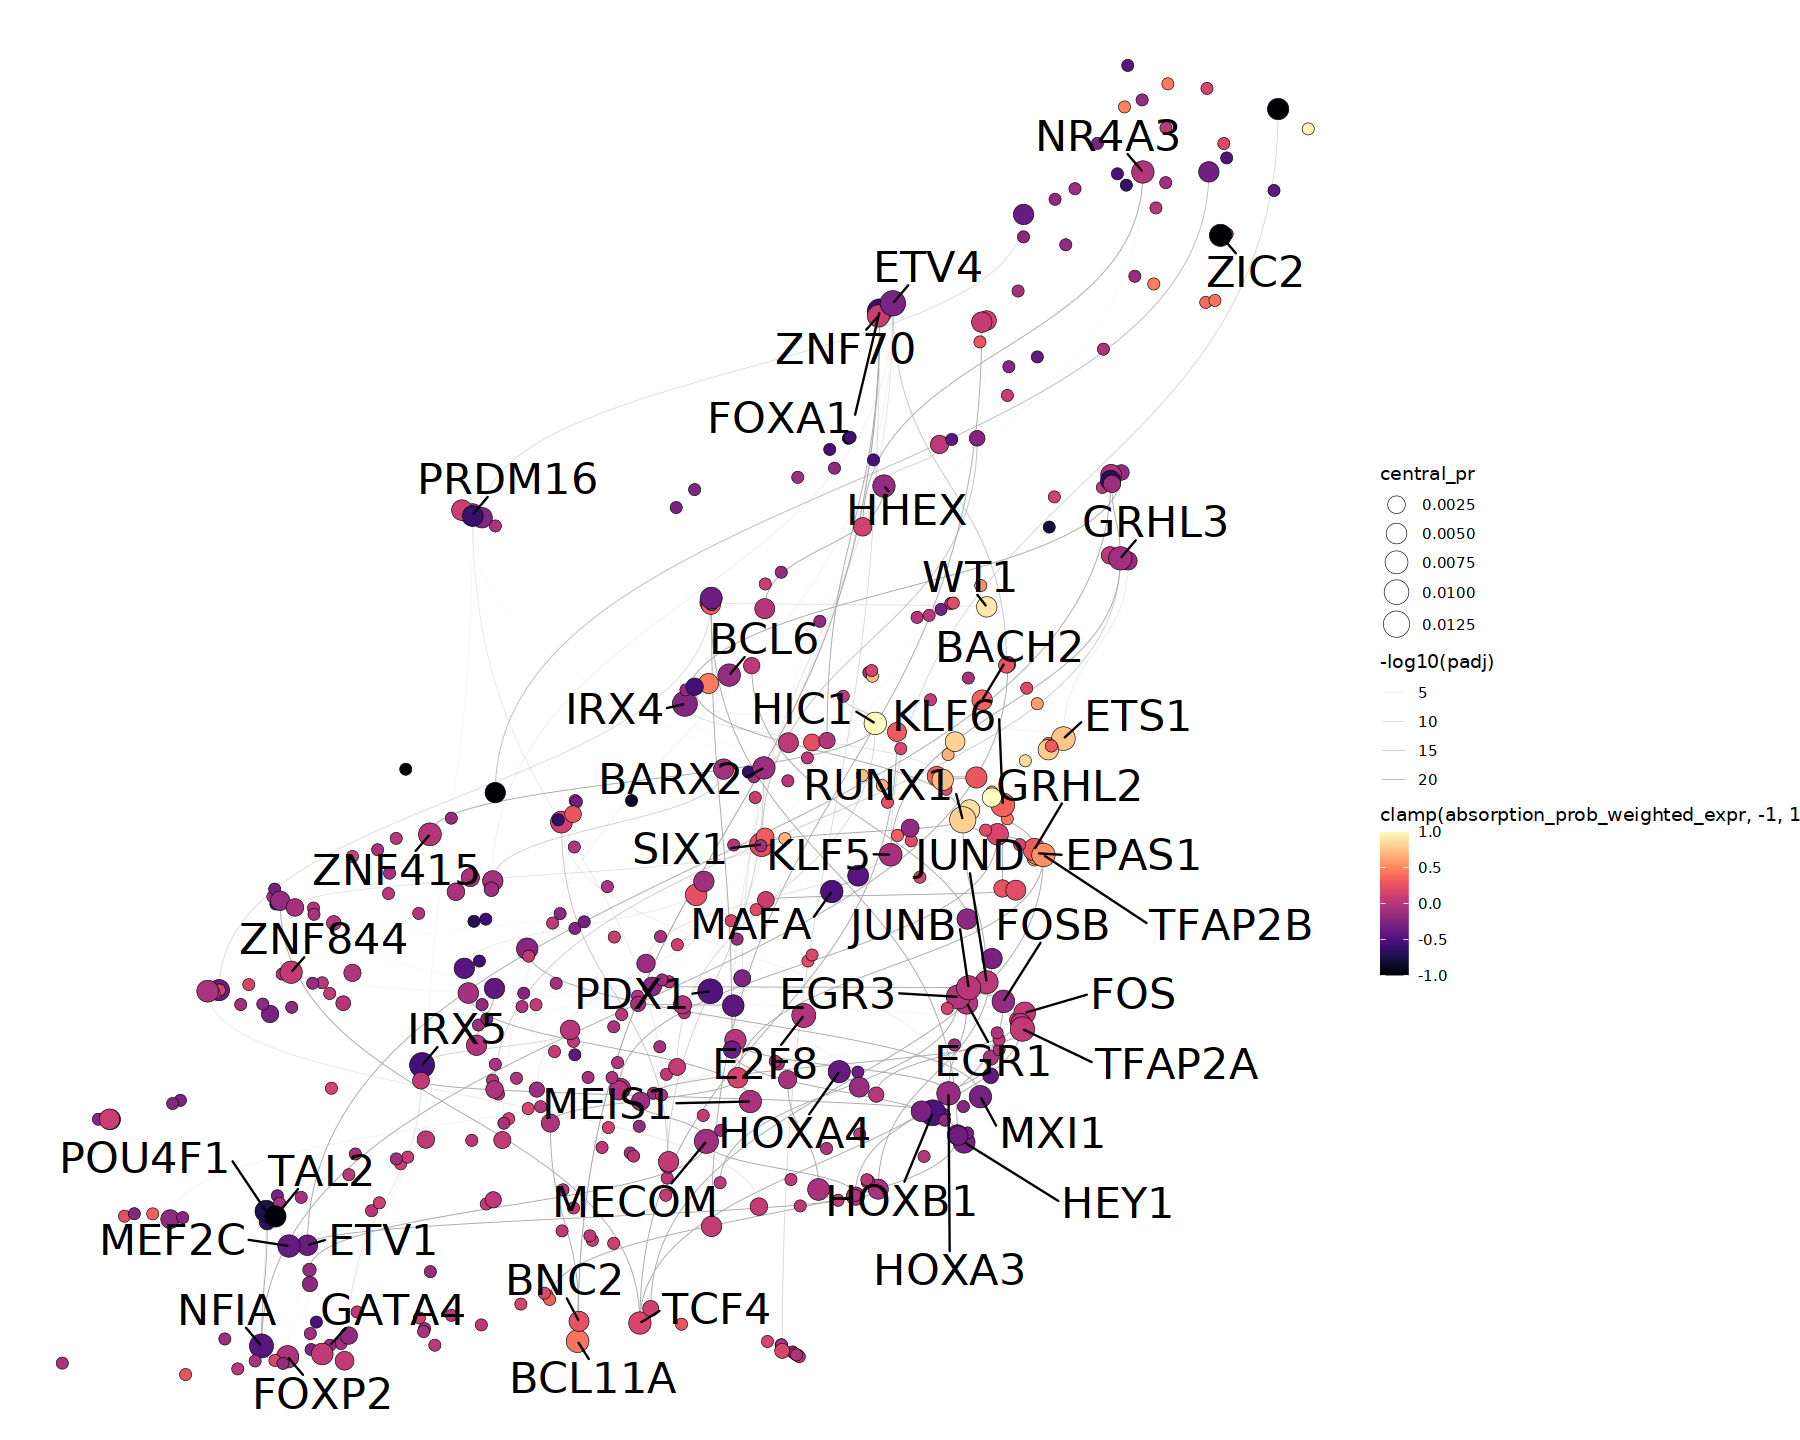

In [60]:
options(repr.plot.width=15, repr.plot.height=12)
# grn_graph %>%
#     filter(UMAP_1 > -1, UMAP_2 > -1) %>%
g <- ggraph(grn_graph, x=UMAP_1, y=UMAP_2) + 
    geom_edge_diagonal(aes(alpha=-log10(padj)), color='darkgray', width=0.2) + 
    geom_node_point(aes(fill=clamp(absorption_prob_weighted_expr, -1,1), size=central_pr), shape=21, stroke=0.2) +
    geom_node_text(aes(label=name, size=central_pr, filter=(name%in% highlight_genes) | (central_pr >= 0.0065)), repel=T, max.overlaps=1000, size=9, min.segment.length=0, box.padding=0.8) +
    #geom_node_text(aes(label=name, size=2)) +
    #scale_edge_color_gradientn(colors=rev(rdbu()), limits=c(-6,6)) +
    scale_edge_alpha_continuous(range=c(0.01,0.8), limits=c(2,20)) +
    scale_size_continuous(range=c(3, 7)) + 
    scale_fill_viridis(option='magma', direction = 1) +
    theme(text=element_text(family='Arial')) + 
    #scale_fill_distiller(palette='RdBu', limits=c(-1, 1), direction=-1)+
    theme_void() #+ no_legend()
g

In [61]:
ggsave(g, filename=paste0(fig_path, 'grn_graph_with_labels.pdf'), device = cairo_pdf, width=15, height=12)

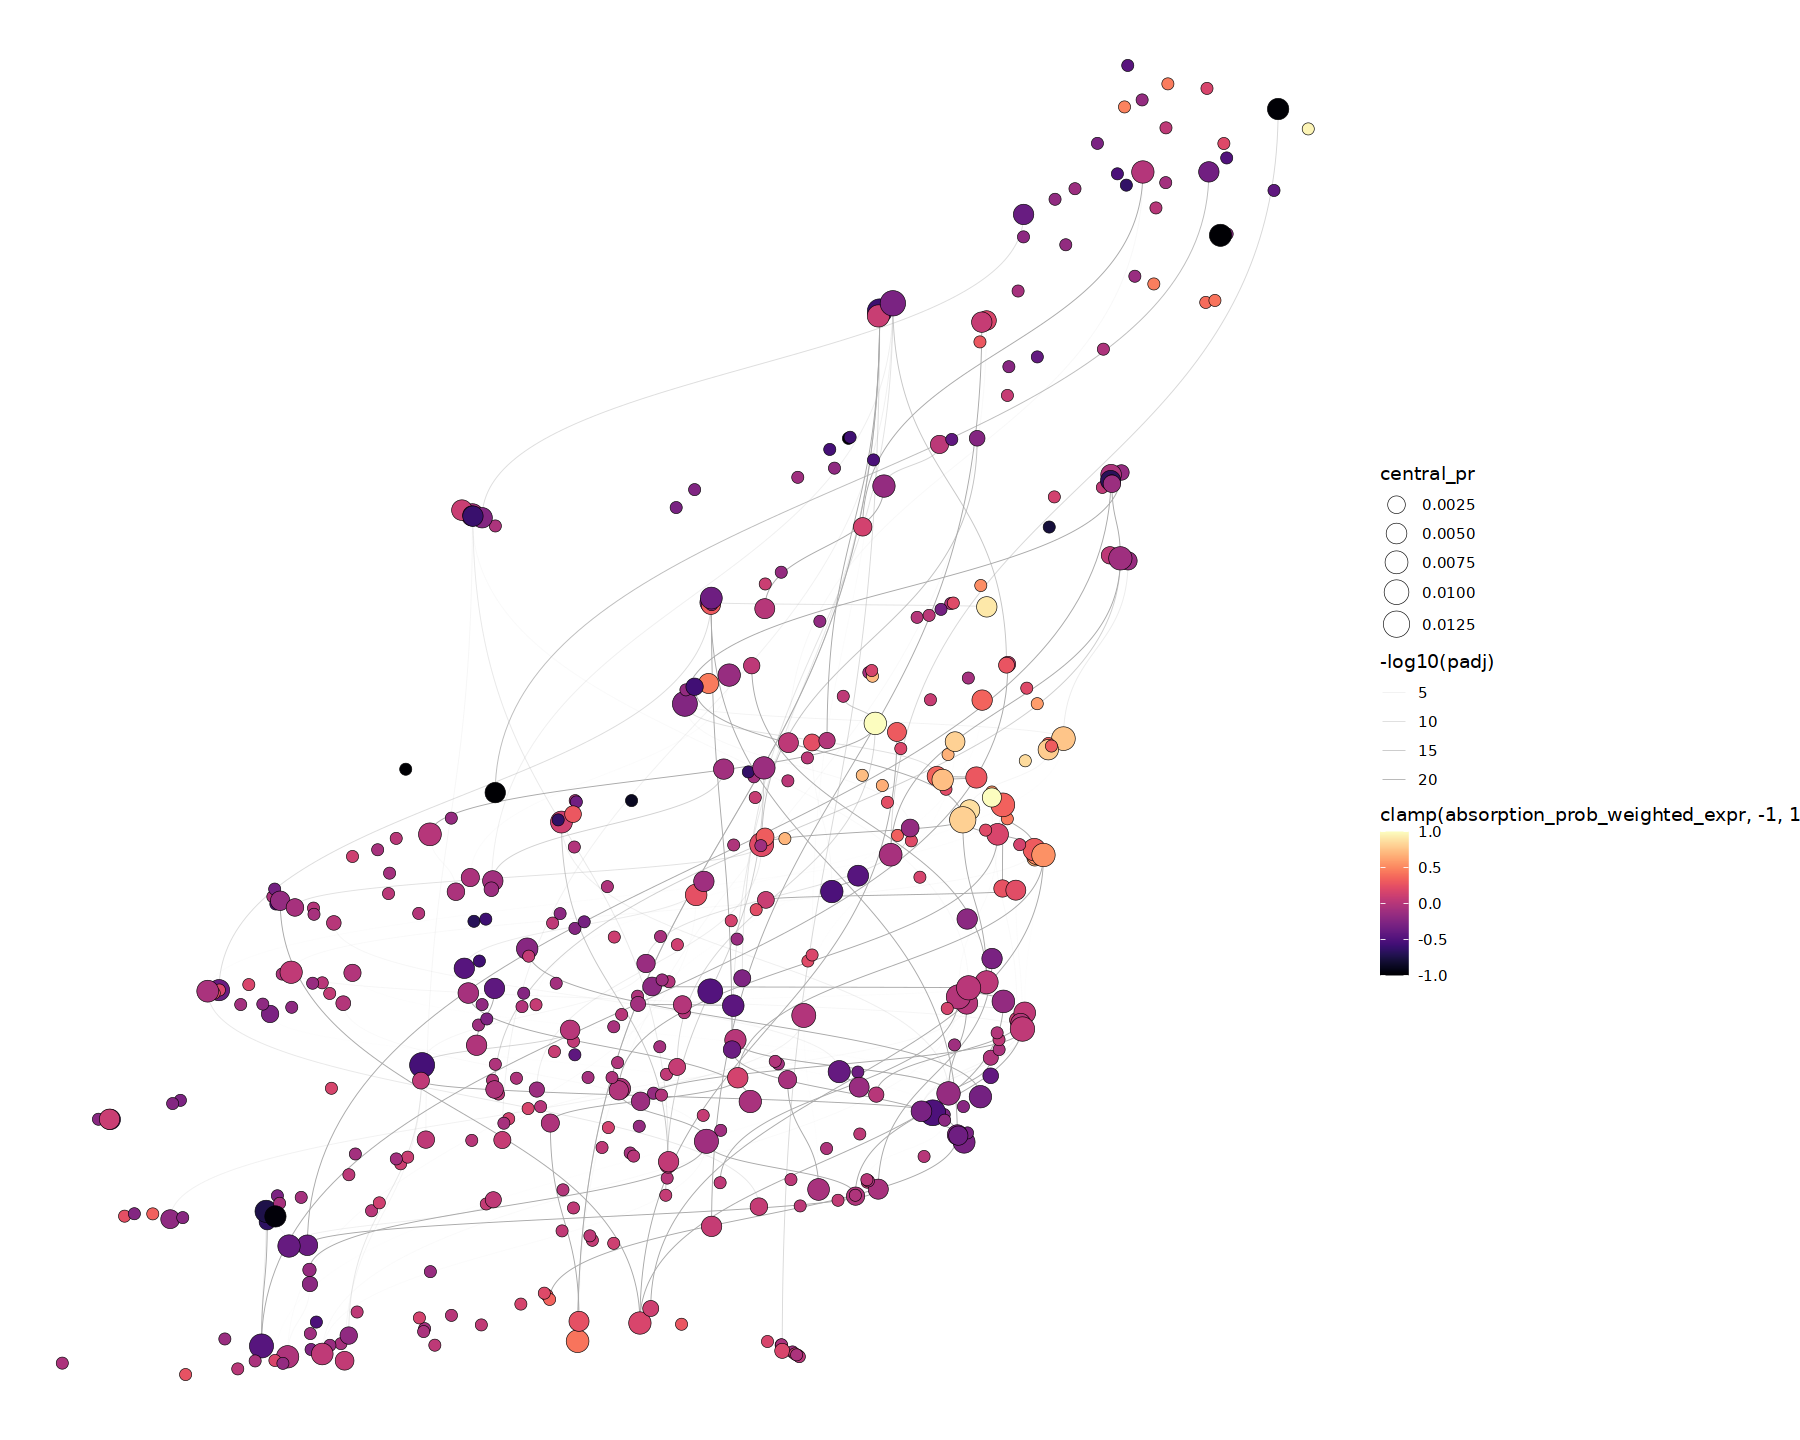

In [62]:
options(repr.plot.width=15, repr.plot.height=12)
# grn_graph %>%
#     filter(UMAP_1 > -1, UMAP_2 > -1) %>%
g <- ggraph(grn_graph, x=UMAP_1, y=UMAP_2) + 
    geom_edge_diagonal(aes(alpha=-log10(padj)), color='darkgray', width=0.2) + 
    geom_node_point(aes(fill=clamp(absorption_prob_weighted_expr, -1,1), size=central_pr), shape=21, stroke=0.2) +
    #geom_node_text(aes(label=name, size=central_pr, filter=(name%in% highlight_genes) | (central_pr >= 0.0065)), repel=T, max.overlaps=1000, size=9, min.segment.length=0, box.padding=0.8) +
    #geom_node_text(aes(label=name, size=2)) +
    #scale_edge_color_gradientn(colors=rev(rdbu()), limits=c(-6,6)) +
    scale_edge_alpha_continuous(range=c(0.01,0.8), limits=c(2,20)) +
    scale_size_continuous(range=c(3, 7)) + 
    scale_fill_viridis(option='magma', direction = 1) +
    theme(text=element_text(family='Arial')) + 
    #scale_fill_distiller(palette='RdBu', limits=c(-1, 1), direction=-1)+
    theme_void() #+ no_legend()
g

In [63]:
ggsave(g, filename=paste0(fig_path, 'grn_graph_no_labels.pdf'), device = cairo_pdf, width=15, height=12)

## Plot TF activity per branch

In [64]:
DefaultAssay(grn_obj) <- "RNA"

### Add absorption probability to grn_obj

In [65]:
rownames(absorption_prob) <- absorption_prob$X

In [66]:
grn_obj <- AddMetaData(grn_obj, absorption_prob)

In [67]:
epi_tfs <- grn_graph %>% filter(absorption_prob_weighted_expr >= 0) %>% pull(name)

In [68]:
cm_tfs <- grn_graph %>% filter(absorption_prob_weighted_expr < 0 ) %>% pull(name)

In [69]:
modules <- modules %>% mutate(Epi=tf%in%epi_tfs, CM=tf%in%cm_tfs)

In [70]:
tf_lineage_expr <- aggregate_matrix(t(GetAssayData(grn_obj)[unique(modules$tf), ]), groups=grn_obj[[]]$cluster)
tf_expr_df <- tf_lineage_expr %>% as_tibble(rownames='lineage') %>% 
    pivot_longer(!lineage, names_to='tf', values_to='expr')

In [71]:
plot_df <- modules %>% 
    #filter(ctx | ge | nt) %>% 
    filter((estimate > -5) & (estimate < 5)) %>%
    group_by(tf) %>% 
    pivot_longer(c(Epi,CM), names_to='lineage', values_to='is_active')%>% 
    inner_join(tf_expr_df) %>% 
    mutate(tf_act=expr*estimate)%>% 
    group_by(tf, lineage) %>% 
    summarize(tf_act=mean(tf_act)) %>% 
    group_by(tf) %>% 
    # filter(n()>1) %>%
    mutate(
        max_est=max(abs(tf_act)),
        span=max(tf_act) - min(tf_act),
        crossing=sign(min(tf_act))!=sign(max(tf_act)),
        abs_span=abs(max(tf_act)) + abs(min(tf_act))
    ) %>% 
    ungroup() %>% 
    group_by(tf) %>% 
    mutate(high_lin=lineage[which.max(abs(tf_act[lineage%in%c('Epi', 'CM')]))]) 

Joining, by = c("tf", "lineage")
`summarise()` has grouped output by 'tf'. You can override using the `.groups`
argument.


In [72]:
epi_high_tfs <- plot_df %>% filter(high_lin=='Epi', lineage=='Epi') %>% mutate(max_act=-max(tf_act)) %>% arrange(max_act) %>% pull(tf)
cm_high_tfs <- plot_df %>% filter(high_lin=='CM', lineage=='CM') %>% mutate(max_act=max(tf_act)) %>% arrange(max_act) %>% pull(tf)
# cross_tfs <- plot_df %>% filter(crossing) %>% arrange(high_lin) %>% pull(tf)

In [73]:
plot_df <- plot_df %>% mutate(tf_name = ifelse((lineage=="CM" & high_lin=="CM") | (lineage=="Epi" & high_lin=="Epi"), tf, NA))

In [74]:
tf_order <- unique(c(epi_high_tfs, cm_high_tfs)) 

Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
Warning message:
“Removed 409 rows containing missing values (`geom_text_repel()`).”


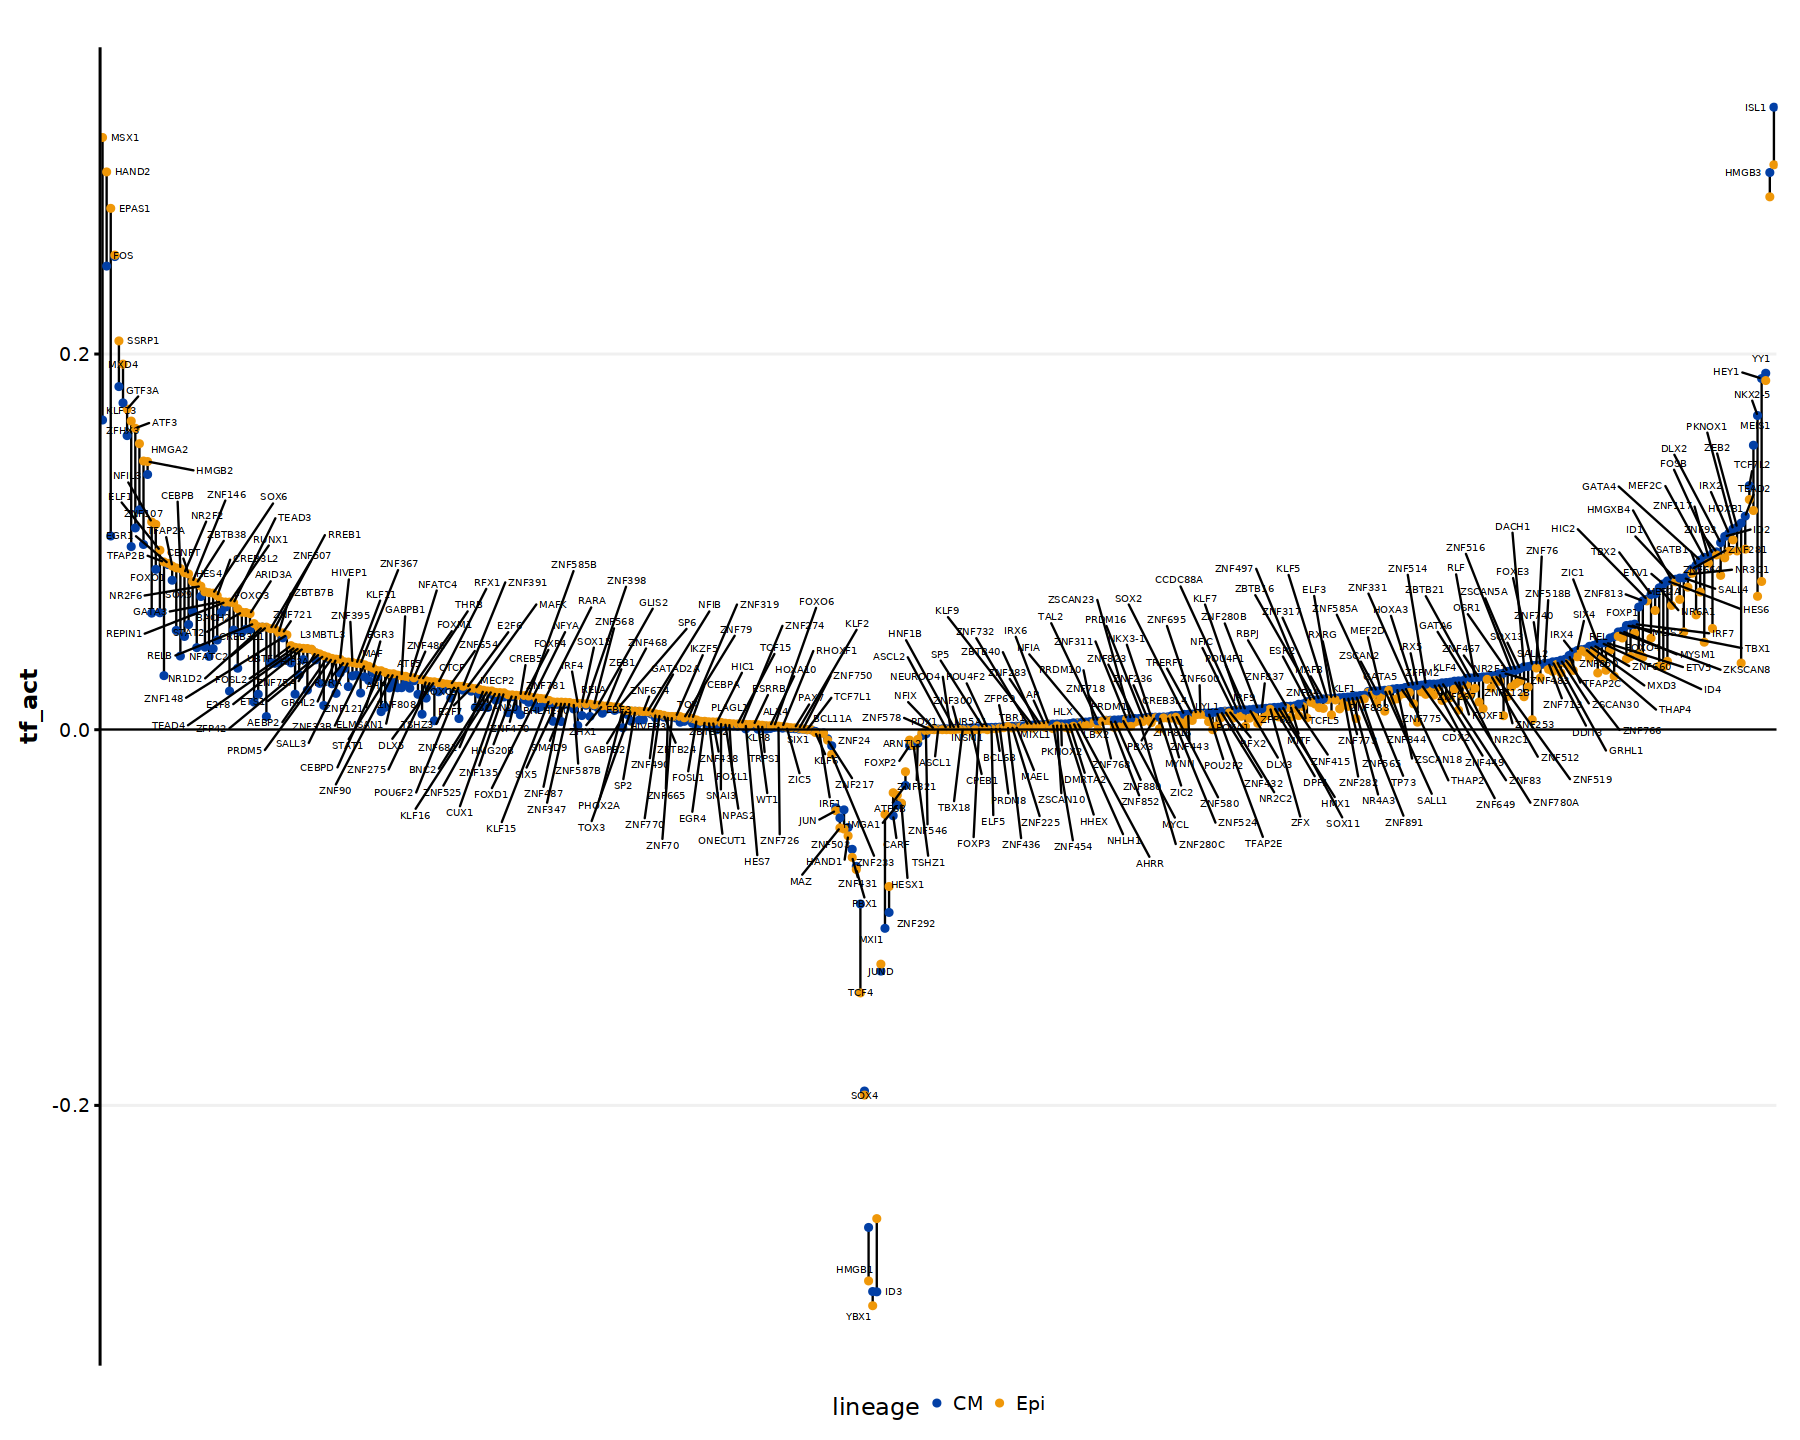

In [78]:
library(ggrepel)
ggplot(plot_df, aes(factor(tf, levels=tf_order), tf_act)) +
    geom_line() +
    geom_point(mapping=aes(color=lineage)) +
    geom_text_repel(mapping=aes(label=tf_name), size=2, angle=0, max.overlaps=1000) +
    geom_hline(yintercept = 0) +
    scale_color_manual(values=c('#023fa5', '#ef9708')) +
    theme(axis.text.x = element_text(size=5)) +
    theme_Publication() + 
    theme(
        axis.line.x = element_blank(),
        axis.ticks.x = element_blank(),
        axis.title.x = element_blank(),
        panel.grid.major.x = element_blank() ,
        #axis.title.y = element_blank()
    ) +
    #no_legend()+
    no_x_text() 

In [79]:
options(repr.plot.width=15, repr.plot.height=8)
g <- ggplot(plot_df, aes(factor(tf, levels=tf_order), tf_act)) +
    geom_line() +
    geom_point(mapping=aes(color=lineage)) +
    geom_text_repel(data=plot_df[(plot_df$tf_name%in% highlight_genes) | abs(plot_df$tf_act) >0.2, ], mapping=aes(label=tf_name), size=8, angle=0, max.overlaps=1000, min.segment.length = 0, box.padding = 0.5) +
    geom_hline(yintercept = 0) +
    scale_color_manual(values=c('#023fa5', '#ef9708')) +
    theme(axis.text.x = element_text(size=5)) +
    theme_Publication() + 
    theme(
        axis.line.x = element_blank(),
        axis.ticks.x = element_blank(),
        axis.title.x = element_blank(),
        panel.grid.major.x = element_blank() ,
        axis.title.y = element_blank(),
        #axis.title.y = element_blank()
    ) +
    #no_legend()+
    no_x_text() 

ggsave(g, filename=paste0(fig_path, 'tf_activity_with_labels.pdf'), device = cairo_pdf, width=15, height=8)

Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
Warning message:
“Removed 7 rows containing missing values (`geom_text_repel()`).”


In [80]:
options(repr.plot.width=15, repr.plot.height=8)
g <- ggplot(plot_df, aes(factor(tf, levels=tf_order), tf_act)) +
    geom_line() +
    geom_point(mapping=aes(color=lineage)) +
    #geom_text_repel(data=plot_df[(plot_df$tf_name%in% highlight_genes) | abs(plot_df$tf_act) >0.2, ], mapping=aes(label=tf_name), size=8, angle=0, max.overlaps=1000, min.segment.length = 0, box.padding = 0.5) +
    geom_hline(yintercept = 0) +
    scale_color_manual(values=c('#023fa5', '#ef9708')) +
    theme(axis.text.x = element_text(size=5)) +
    theme_Publication() + 
    theme(
        axis.line.x = element_blank(),
        axis.ticks.x = element_blank(),
        axis.title.x = element_blank(),
        panel.grid.major.x = element_blank() ,
        axis.title.y = element_blank(),
        #axis.title.y = element_blank()
    ) +
    #no_legend()+
    no_x_text() 
ggsave(g, filename=paste0(fig_path, 'tf_activity_without_labels.pdf'), device = cairo_pdf, width=15, height=8)

Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”


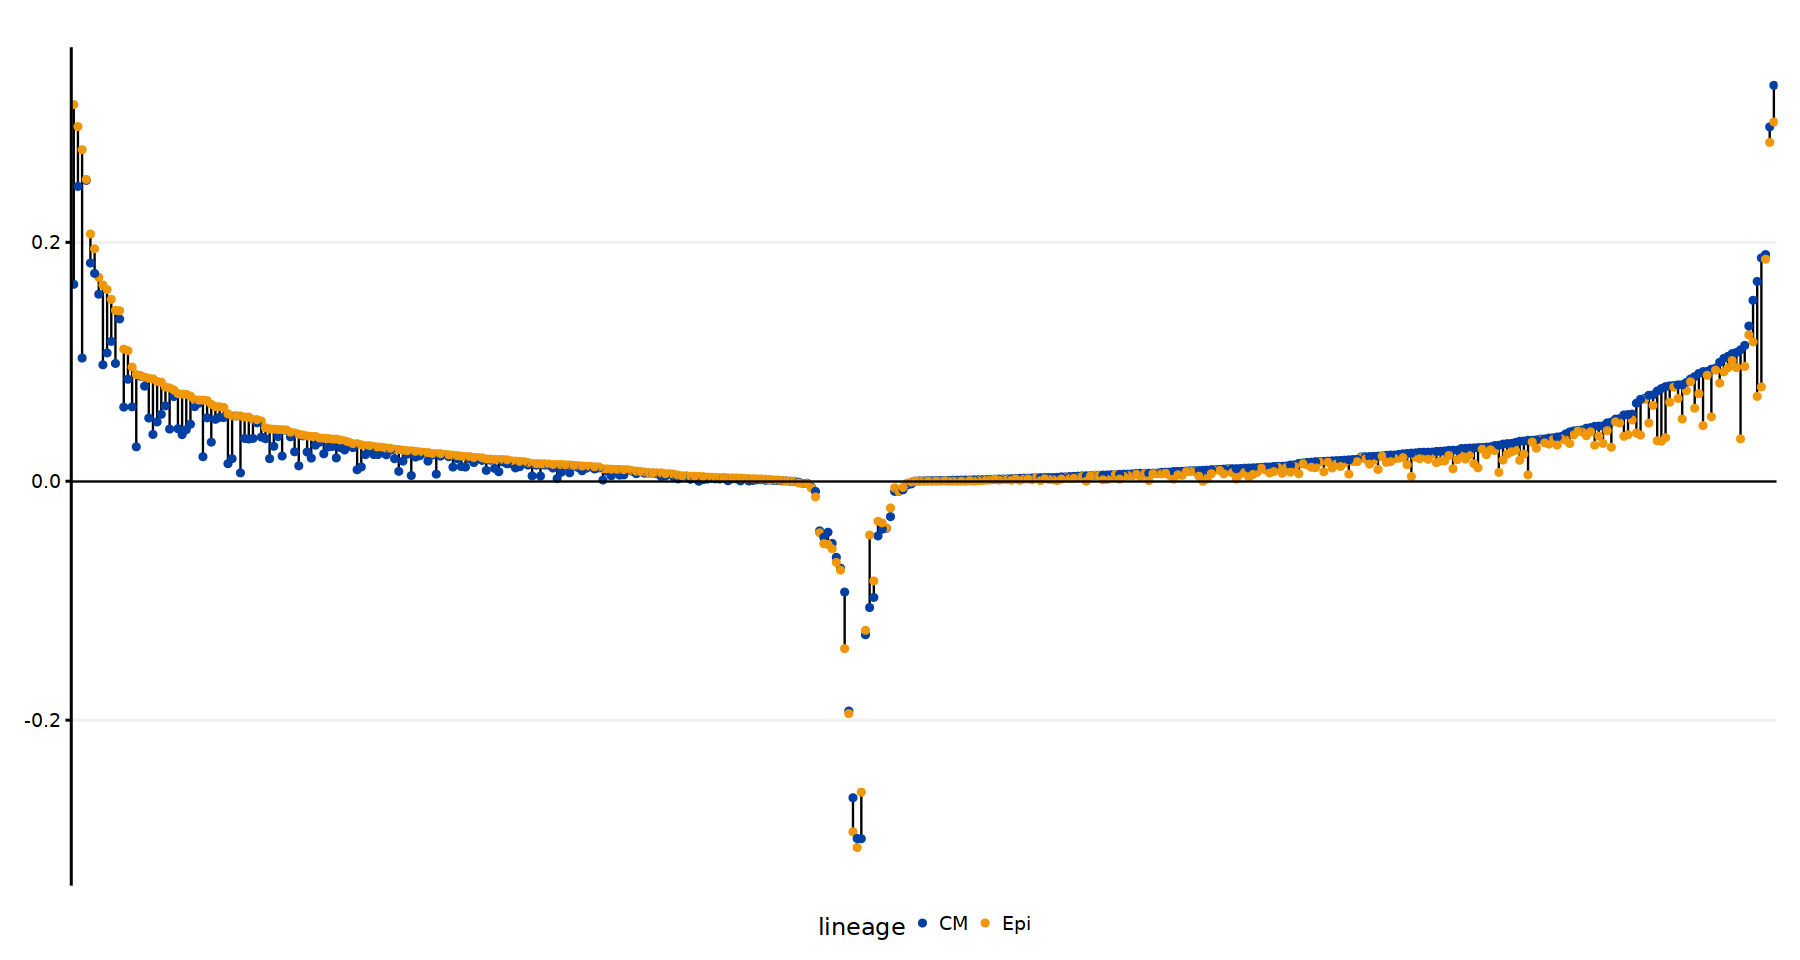

In [81]:
g

### Save as supplementary

In [102]:
epi <- plot_df %>% filter((high_lin == 'Epi') & (lineage == 'Epi')) %>% dplyr::select(c(tf, lineage, tf_act))

In [103]:
epi <- epi %>% mutate(positive_targets = modules_pos[tf], negative_targets = modules_neg[tf])

In [130]:
epi %>% filter(tf=='TFAP2B')

tf,lineage,tf_act,positive_targets,negative_targets
<chr>,<chr>,<dbl>,<named list>,<named list>
TFAP2B,Epi,0.0893016,"AHNAK , CDC42EP1, CGN , ELMOD1 , EPAS1 , F11R , FUT8 , GPC5 , KCNMA1 , KRT19 , MXRA8 , PDLIM1 , PRSS23 , RIMS2 , SLC28A2 , SPINT2 , SWAP70 , TGIF1 , VTCN1 , WNT6 , WNT7B",METRN


In [124]:
epi <- epi %>% mutate_all(~replace(., . == 'NULL', NA))

`mutate_all()` ignored the following grouping variables:
• Column `tf`
ℹ Use `mutate_at(df, vars(-group_cols()), myoperation)` to silence the message.


In [125]:
fwrite(epi, '/lustre/groups/ml01/workspace/laura.martens/moretti_colab/panels/jcf/epi_activity_targets.csv')

In [100]:
cm <- plot_df %>% filter((high_lin == 'CM') & (lineage == 'CM')) %>% dplyr::select(c(tf, lineage, tf_act))

In [101]:
cm <- cm %>% mutate(positive_targets = modules_pos[tf], negative_targets = modules_neg[tf])

In [126]:
cm <- cm %>% mutate_all(~replace(., . == 'NULL', NA))

`mutate_all()` ignored the following grouping variables:
• Column `tf`
ℹ Use `mutate_at(df, vars(-group_cols()), myoperation)` to silence the message.


In [127]:
fwrite(cm, '/lustre/groups/ml01/workspace/laura.martens/moretti_colab/panels/jcf/cm_activity_targets.csv')

#### Add embedding

In [285]:
grn_obj <- RunUMAP(grn_obj, dims=1:50)

18:04:11 UMAP embedding parameters a = 0.9922 b = 1.112

18:04:11 Read 893 rows and found 50 numeric columns

18:04:11 Using Annoy for neighbor search, n_neighbors = 30

18:04:11 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

18:04:12 Writing NN index file to temp file /tmp/RtmplgF55p/file18fb838da1b18

18:04:12 Searching Annoy index using 1 thread, search_k = 3000

18:04:12 Annoy recall = 100%

18:04:13 Commencing smooth kNN distance calibration using 1 thread

18:04:16 Initializing from normalized Laplacian + noise

18:04:16 Commencing optimization for 500 epochs, with 37528 positive edges

18:04:20 Optimization finished



In [300]:
grn_obj@reductions$xglue_umap = grn_obj@reductions$umap

In [ ]:
xglue_umap <- adata$obsm$X_umap

rownames(xglue_umap) <- adata$obs_names

colnames(xglue_umap) <- c("UMAP_1", "UMAP_2")

In [ ]:
grn_obj@reductions$xglue_umap@cell.embeddings <- xglue_umap[colnames(grn_obj), ]

In [ ]:
grn_obj@reductions$umap = grn_obj@reductions$xglue_umap

Warning message:
“Could not find WNT7B in the default search locations, found in RNA assay instead”
Warning message:
“Could not find FOXL1 in the default search locations, found in RNA assay instead”
Warning message:
“Could not find MLLT10 in the default search locations, found in RNA assay instead”
Warning message in FetchData.Seurat(object = object, vars = c(dims, "ident", features), :
“The following requested variables were not found: Epicardial”


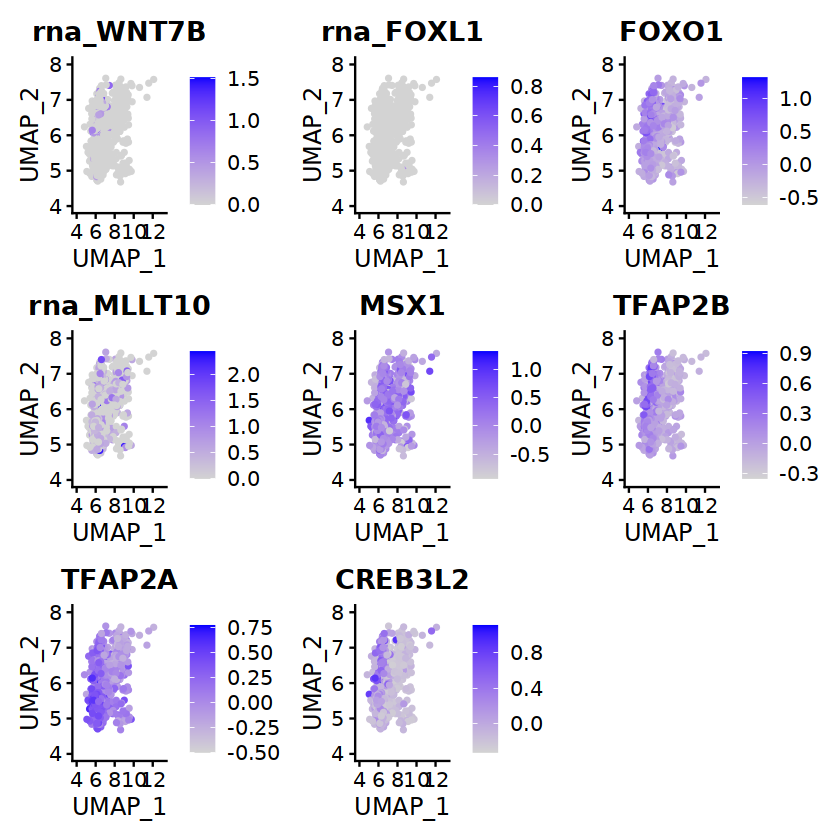

In [38]:
FeaturePlot(grn_obj, features = c("WNT7B", "FOXL1", "FOXO1", "MLLT10", "MSX1", "TFAP2B", "TFAP2A", "CREB3L2", "Epicardial"), reduction = 'xglue_umap', dim=1:2)

In [37]:
grn_obj

An object of class SeuratPlus 
186346 features across 893 samples within 3 assays 
Active assay: module_scores (172 features, 0 variable features)
 2 other assays present: peaks, RNA
 4 dimensional reductions calculated: pca, lsi, umap, xglue_umap

### Call differential peaks based on clusters

In [101]:
DefaultAssay(grn_obj) <- 'peaks'

In [43]:
rownames(absorption_prob) <- absorption_prob$X

In [44]:
grn_obj <- AddMetaData(grn_obj, absorption_prob)

In [125]:
da_peaks <- FindMarkers(
  object = grn_obj,
  ident.1 = "CM",
  ident.2 = "Epi",
  test.use = 'LR',
  group.by='cluster',
  #latent.vars = 'nCount_peaks',
 min.pct=0.05
)

In [126]:
da_peaks <- da_peaks %>% filter(p_val_adj < 0.1)

In [127]:
peaks_epi <- da_peaks %>% filter(avg_log2FC < 0)

In [128]:
peaks_cm <- da_peaks %>% filter(avg_log2FC > 0)

In [130]:
peaks_cm

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr6-54743763-54744609,3.142239e-07,0.2689241,0.135,0.042,0.05090521
chr2-200557203-200557524,4.042450e-07,0.2970403,0.065,0.003,0.06548890


## Add module scores

In [91]:
module_targets <- NetworkModules(grn_obj)@features$genes_pos

In [92]:
modules_pos <- modules %>% 
    filter((estimate > 0) & (estimate < 5)) %>% 
    group_by(tf) %>% 
    group_split() %>% {names(.) <- map_chr(., function(x) x$tf[[1]]); .} %>% 
    map(function(x) x$target)

In [93]:
modules_neg <- modules %>% 
    filter((estimate < 0) & (estimate > -5)) %>% 
    group_by(tf) %>% 
    group_split() %>% {names(.) <- map_chr(., function(x) x$tf[[1]]); .} %>% 
    map(function(x) x$target)

### Save modules

In [80]:
genes_pos <- map_dfr(modules_pos, ~as_data_frame(t(.))) %>% as.data.frame()
rownames(genes_pos) <- names(modules_pos)

write.csv(genes_pos, '/lustre/groups/ml01/workspace/laura.martens/moretti_colab/panels/jcf/positive_tf_target_groups.csv')

Warning message:
“`as_data_frame()` was deprecated in tibble 2.0.0.
ℹ Please use `as_tibble()` instead.
ℹ The signature and semantics have changed, see `?as_tibble`.”
Warning message:
“The `x` argument of `as_tibble.matrix()` must have unique column names if
`.name_repair` is omitted as of tibble 2.0.0.
ℹ Using compatibility `.name_repair`.
ℹ The deprecated feature was likely used in the tibble package.
  Please report the issue at <https://github.com/tidyverse/tibble/issues>.”


In [81]:
genes_neg <- map_dfr(modules_neg, ~as_data_frame(t(.)))%>% as.data.frame()
rownames(genes_neg) <- names(modules_neg)

write.csv(genes_neg, '/lustre/groups/ml01/workspace/laura.martens/moretti_colab/panels/jcf/negative_tf_target_groups.csv')


In [217]:
modules_pos$GATA4

[1] "DPF3"          "NEBL"          "RP11-332H18.4"

In [219]:
modules_pos$TFAP2B

[1] "AHNAK"    "CDC42EP1" "CGN"      "ELMOD1"   "EPAS1"    "F11R"    
 [7] "FUT8"     "GPC5"     "KCNMA1"   "KRT19"    "MXRA8"    "PDLIM1"  
[13] "PRSS23"   "RIMS2"    "SLC28A2"  "SPINT2"   "SWAP70"   "TGIF1"   
[19] "VTCN1"    "WNT6"     "WNT7B"

In [220]:
modules_pos$TFAP2A

[1] "CLDN6"    "COL11A2"  "CYP26A1"  "HOXA1"    "HOXB-AS1" "KRT19"   
 [7] "METRN"    "NES"      "PRSS8"    "SLC29A1"  "SMTNL2"   "SPINT2"  
[13] "WNT7B"    "ZNF703"

In [221]:
modules_neg$TFAP2B

[1] "METRN"

In [222]:
modules_neg$TFAP2A

[1] "HOXA3"  "KISS1"  "NDRG2"  "PDGFRA" "PTMA"

In [218]:
modules_neg$GATA4

[1] "LRP2"

### Score modules

In [94]:
DefaultAssay(grn_obj) <- "RNA"


In [98]:
grn_obj@meta.data <- grn_obj[[]] %>% select(!contains("gene_"))

### Positive modules

In [99]:
grn_obj <- AddModuleScore(
    grn_obj, 
    features = modules_pos, 
    pool=VariableFeatures(grn_obj), 
    name='gene_pos'
)

In [100]:
module_names <- names(modules_pos)

In [101]:
names(module_names) <- str_replace(
    colnames(grn_obj[[]][, str_detect(colnames(grn_obj[[]]), 'gene_')]) , '-', '-')

In [102]:
module_scores <- grn_obj[[]] %>% select(contains("gene_"))
colnames(module_scores) <- module_names[colnames(module_scores)] 

In [104]:
grn_obj[['module_scores_pos']] <- CreateAssayObject(counts = t(module_scores))

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from module_scores_pos_ to modulescorespos_”


### Negative modules

In [105]:
grn_obj@meta.data <- grn_obj[[]] %>% select(!contains("gene_"))

In [106]:
grn_obj <- AddModuleScore(
    grn_obj, 
    features = modules_neg, 
    pool=VariableFeatures(grn_obj), 
    name='gene_neg'
)

In [107]:
module_names <- names(modules_neg)

In [108]:
names(module_names) <- str_replace(
    colnames(grn_obj[[]][, str_detect(colnames(grn_obj[[]]), 'gene_')]) , '-', '-')

In [109]:
module_scores <- grn_obj[[]] %>% select(contains("gene_"))
colnames(module_scores) <- module_names[colnames(module_scores)] 

In [110]:
grn_obj[['module_scores_neg']] <- CreateAssayObject(counts = t(module_scores))

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from module_scores_neg_ to modulescoresneg_”


In [111]:
DefaultAssay(grn_obj) <- 'module_scores_pos'

### Save module scores

In [118]:
GetAssayData(grn_obj, assay='module_scores_pos') %>% as.data.frame() %>% t() %>% write.csv(paste0(fig_path, "module_score_pos.csv"))

In [119]:
GetAssayData(grn_obj, assay='module_scores_neg') %>% as.data.frame() %>% t() %>% write.csv(paste0(fig_path, "module_score_neg.csv"))

#### Add embedding

In [29]:
grn_obj <- RunUMAP(grn_obj, dims=1:50)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
14:26:44 UMAP embedding parameters a = 0.9922 b = 1.112

14:26:44 Read 893 rows and found 50 numeric columns

14:26:44 Using Annoy for neighbor search, n_neighbors = 30

14:26:44 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:26:44 Writing NN index file to temp file /tmp/Rtmp3o68Mm/file358674d23536e

14:26:44 Searching Annoy index using 1 thread, search_k = 3000

14:26:44 Annoy recall = 100%

14:26:45 Commencing smooth kNN distance calibration using 1 thread

14:26:47 Initializing fro

In [30]:
grn_obj@reductions$xglue_umap = grn_obj@reductions$umap

In [289]:
xglue_umap <- adata$obsm$X_umap

rownames(xglue_umap) <- adata$obs_names

colnames(xglue_umap) <- c("UMAP_1", "UMAP_2")

In [301]:
grn_obj@reductions$xglue_umap@cell.embeddings <- xglue_umap[colnames(grn_obj), ]

In [322]:
grn_obj@reductions$umap = grn_obj@reductions$xglue_umap

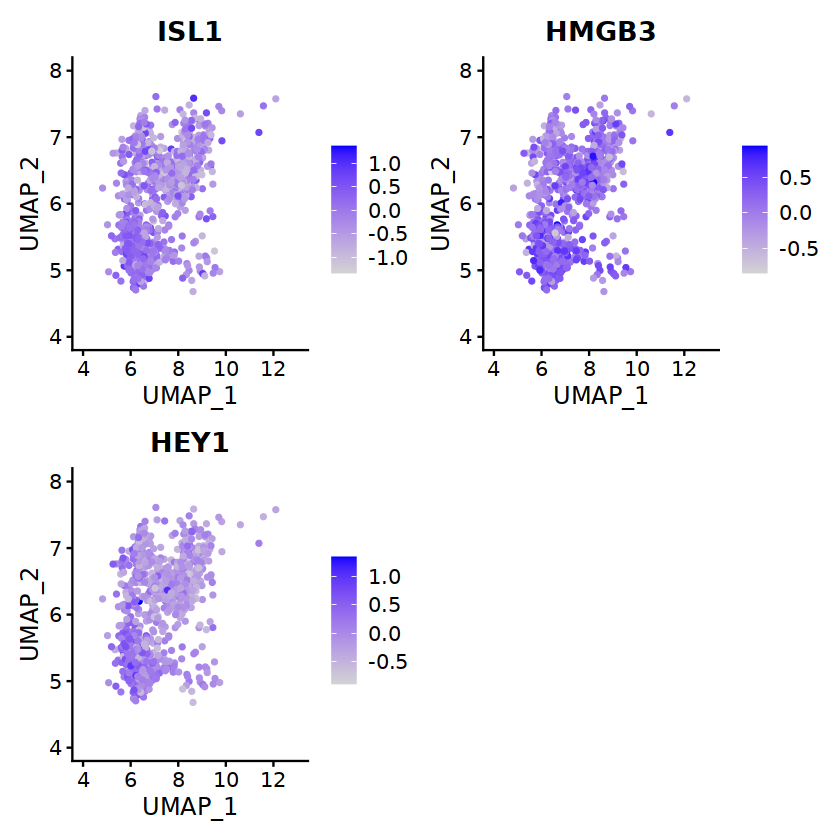

In [112]:
FeaturePlot(grn_obj, features = c("ISL1", "HMGB3", "HEY1"), reduction = 'xglue_umap', dim=1:2)

### Fit module score as a function of absorption probability

In [114]:
grn_obj@meta.data <- grn_obj@meta.data %>% 
  as_tibble(rownames='cell') %>% 
  group_by(cluster) %>% 
  mutate(pseudotime_align=rank(pr_pseudotime)/n())

In [115]:
model_frame <- data.frame(
  lineage=factor(grn_obj$cluster),
  pt=grn_obj$pseudotime_align
)

In [116]:
module_mat <- t(grn_obj[['module_scores']]@data)

In [117]:
# module_mat <- t(rnatac[['RNA']]@data[rownames(rnatac[['module_score']]), cells_use])
colnames(module_mat) <- str_replace(colnames(module_mat), '-', '_')

In [118]:
module_fit_list <- lapply(1:ncol(module_mat), function(i){
  model_formula <- reformulate(colnames(model_frame), response=colnames(module_mat)[i])
  model_data <- cbind(module_mat[,i,drop=F], model_frame)
  return(fit_glm(formula=model_formula, data=model_data))
})

In [119]:
names(module_fit_list) <- colnames(module_mat)
comb_model_coefs <- map_dfr(module_fit_list, function(x) x$coefs, .id='module')
comb_model_gof <- map_dfr(module_fit_list, function(x) x$gof, .id='module')

In [120]:
module_lin_fit_list <- lapply(1:ncol(module_mat), function(i){
  model_formula <- reformulate('lineage', response=colnames(module_mat)[i])
  model_data <- cbind(module_mat[,i,drop=F], model_frame)
  return(fit_glm(formula=model_formula, data=model_data))
})

In [122]:
names(module_lin_fit_list) <- colnames(module_mat)
lin_model_coefs <- map_dfr(module_lin_fit_list, function(x) x$coefs, .id='module')
lin_model_gof <- map_dfr(module_lin_fit_list, function(x) x$gof, .id='module')

module_pt_fit_list <- lapply(1:ncol(module_mat), function(i){
  model_formula <- reformulate('pt', response=colnames(module_mat)[i])
  model_data <- cbind(module_mat[,i,drop=F], model_frame)
  return(fit_glm(formula=model_formula, data=model_data))
})
names(module_pt_fit_list) <- colnames(module_mat)
pt_model_coefs <- map_dfr(module_pt_fit_list, function(x) x$coefs, .id='module')
pt_model_gof <- map_dfr(module_pt_fit_list, function(x) x$gof, .id='module')


comb_model_df <- inner_join(comb_model_coefs, comb_model_gof)
lin_model_df <- inner_join(lin_model_coefs, lin_model_gof)
pt_model_df <- inner_join(pt_model_coefs, pt_model_gof)


gof <- bind_rows('lin_pt'=comb_model_gof, 'lin'=lin_model_gof, 'pt'=pt_model_gof, .id='vars') %>% 
  mutate(module=str_replace_all(module, '_', '-'))
coefs <- bind_rows('lin_pt'=comb_model_coefs, 'lin'=lin_model_coefs, 'pt'=pt_model_coefs, .id='vars') %>% 
  mutate(module=str_replace_all(module, '_', '-'))
coefs <- coefs %>% mutate(term=str_remove_all(term, 'lineage'))

Joining, by = "module"
Joining, by = "module"
Joining, by = "module"


In [123]:
# gof %>% write_tsv('data/RNA_ATAC/grn/module_lineage_pt_r2.tsv')
# coefs %>% write_tsv('data/RNA_ATAC/grn/module_lineage_pt_coefs.tsv')

mean_lineage_score <- aggregate_matrix(module_mat, model_frame$lineage)
module_max_lineage <- rownames(mean_lineage_score)[apply(mean_lineage_score, 2, which.max)]
names(module_max_lineage) <- colnames(mean_lineage_score)
module_max_lineage <- enframe(module_max_lineage, 'module', 'module_lineage') %>% 
  mutate(module=str_replace_all(module, '_', '-'))

In [126]:
# gof <- read_tsv('data/RNA_ATAC/grn/module_lineage_pt_r2.tsv')
# coefs <- read_tsv('data/RNA_ATAC/grn/module_lineage_pt_coefs.tsv')

gof_meta <- gof %>% 
  #inner_join(gene_meta, by=c('module'='gene')) %>% 
  inner_join(module_max_lineage) %>% 
  mutate(vars=factor(vars, levels=c('lin', 'pt', 'lin_pt')))

Joining, by = "module"


In [ ]:
library(ggbeeswarm)
library(ggthemr)


Attaching package: ‘ggthemr’


The following objects are masked from ‘package:Pando’:

    no_legend, no_x_text, no_y_text




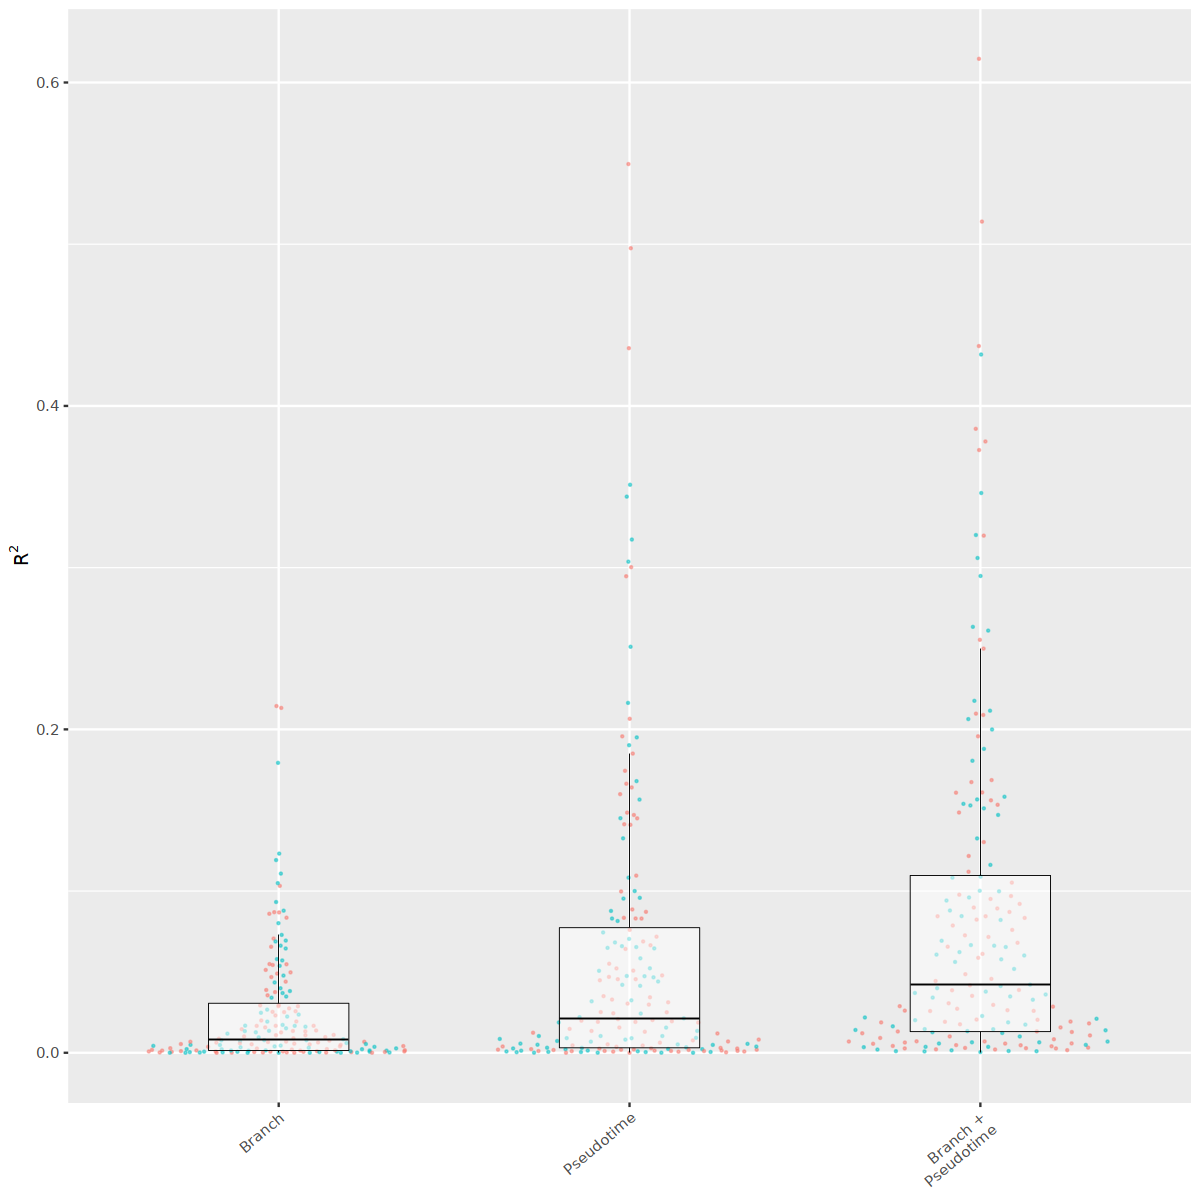

In [142]:
ggplot(gof_meta, aes(vars, rsq, color=module_lineage)) +
  geom_quasirandom(alpha=0.5, size=0.2) +
  geom_boxplot(color='black', alpha=0.5, outlier.shape = NA, width=0.4, size=0.2) +
  #scale_color_manual(values=lineage_colors) +
  scale_x_discrete(labels=c('lin'='Branch', 'pt'='Pseudotime', 'lin_pt'='Branch +\nPseudotime')) +
  rotate_x_text(40) +
  no_legend() + 
  labs(y=bquote(R^2)) +
  theme(
    axis.title.x = element_blank()
  )

Warning message:
“ggrepel: 122 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


$x
[1] "Variance explained by branch"

$y
[1] "Variance explained by pseudotime"

attr(,"class")
[1] "labels"

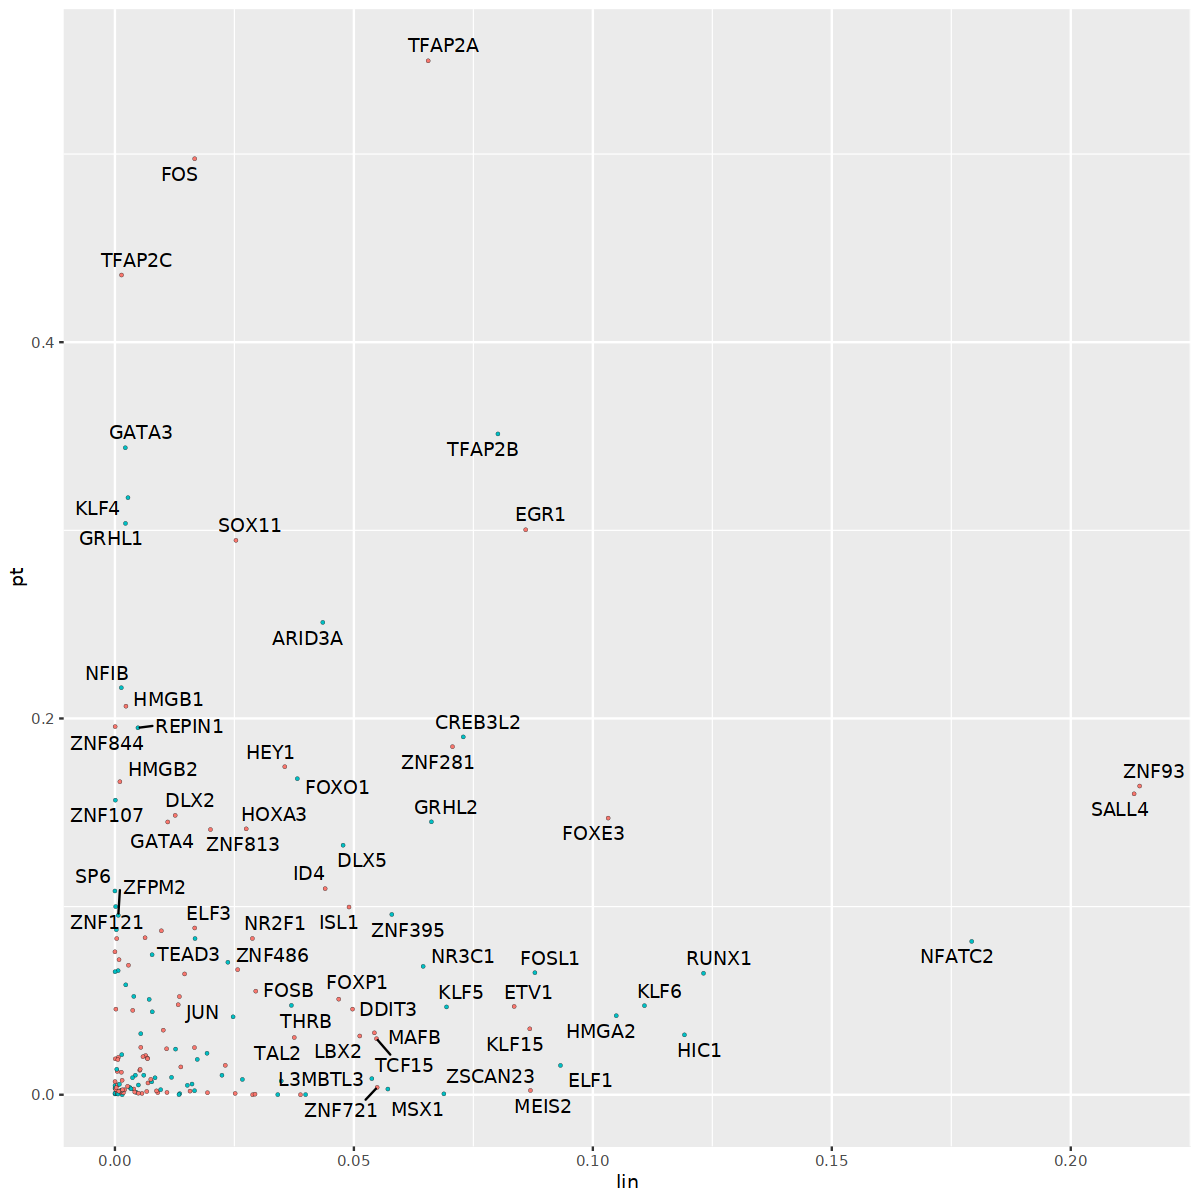

In [149]:
gof_wide <- gof_meta %>% 
  pivot_wider(names_from='vars', values_from='rsq') 

ggplot(gof_wide, aes(lin, pt, fill=module_lineage)) +
  geom_point(data=gof_wide, shape=21, stroke=0.1, size=0.8) +
  #scale_fill_manual(values=lineage_colors) +
 no_legend() + 
 geom_text_repel(aes(label=module))
  labs(x='Variance explained by branch', y='Variance explained by pseudotime') 

In [81]:
da_modules <- FindMarkers(
  object = grn_obj,
  ident.1 = "CM",
  ident.2 = "Epi",
  test.use = 'wilcox',
  group.by='cluster',
  #latent.vars = 'nCount_peaks',
    min.pct=0.05
)

In [87]:
rownames(da_modules) <- module_names[rownames(da_modules)]